<a href="https://colab.research.google.com/github/mobarakol/Class-Distribution-Aware_TS_LS/blob/main/CDA_TS_LS_Paper_Metrics_Plots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Class-Distribution-Aware Calibration for Long-Tailed Visual Recognition

Despite impressive accuracy, deep neural networks are often miscalibrated and tend to overly confident predictions. Recent techniques like temperature scaling (TS) and label smoothing (LS) show effectiveness in obtaining a well-calibrated model by smoothing logits and hard labels with scalar factors, respectively. However, the use of uniform TS or LS factor may not be optimal for calibrating models trained on a long-tailed dataset where the model produces overly confident probabilities for high-frequency classes. In this study, we propose class-distribution-aware TS (CDA-TS) and LS (CDA-LS) by incorporating class frequency information in model calibration in the context of long-tailed distribution. In CDA-TS, the scalar temperature value is replaced with the CDA temperature vector with larger values for high-frequency classes to compensate for the over-confidence. Similarly, CDA-LS uses a vector smoothing factor and flattens the hard labels according to their corresponding class distribution. We also integrate CDA optimal temperature vector with distillation loss, which reduces miscalibration in self-distillation (SD). We empirically show that class-distribution-aware TS and LS can accommodate the imbalanced data distribution yielding superior performance in both calibration error and predictive accuracy. We also observe that SD with an extremely imbalanced dataset is less effective in terms of calibration performance.

Model:ResNet18

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=100):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2,2,2,2])



Utils: Calibration Metrics

In [2]:
import os
import random
import numpy as np
import torch

def get_ece(preds, targets, n_bins=10, **args):
    bin_boundaries = np.linspace(0, 1, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]
    
    confidences, predictions = np.max(preds, 1), np.argmax(preds, 1)
    accuracies = (predictions == targets)
    
    ece = 0.0
    avg_confs_in_bins = []
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        in_bin = np.logical_and(confidences > bin_lower, confidences <= bin_upper)
        prop_in_bin = np.mean(in_bin)
        if prop_in_bin > 0:
            accuracy_in_bin = np.mean(accuracies[in_bin])
            avg_confidence_in_bin = np.mean(confidences[in_bin])
            delta = avg_confidence_in_bin - accuracy_in_bin
            avg_confs_in_bins.append(delta)
            ece += np.abs(delta) * prop_in_bin
        else:
            avg_confs_in_bins.append(None)
    # For reliability diagrams, also need to return these:
    # return ece, bin_lowers, avg_confs_in_bins
    return ece

def get_sce(preds, targets, n_bins=10, **args):
    bin_boundaries = np.linspace(0, 1, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]
    
    n_objects, n_classes = preds.shape
    res = 0.0
    for cur_class in range(n_classes):
        for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
            cur_class_conf = preds[:, cur_class]
            in_bin = np.logical_and(cur_class_conf > bin_lower, cur_class_conf <= bin_upper)

            # cur_class_acc is ground truth probability of chosen class being the correct one inside the bin.
            # NOT fraction of correct predictions in the bin
            # because it is compared with predicted probability
            bin_acc = (targets[in_bin] == cur_class)
            
            bin_conf = cur_class_conf[in_bin]

            bin_size = np.sum(in_bin)
            
            if bin_size > 0:
                avg_confidence_in_bin = np.mean(bin_conf)
                avg_accuracy_in_bin = np.mean(bin_acc)
                delta = np.abs(avg_confidence_in_bin - avg_accuracy_in_bin)
#                 print(f'bin size {bin_size}, bin conf {avg_confidence_in_bin}, bin acc {avg_accuracy_in_bin}')
                res += delta * bin_size / (n_objects * n_classes)
    return res

def get_tace(preds, targets, n_bins=15, threshold=1e-3, **args):
    n_objects, n_classes = preds.shape
    
    res = 0.0
    for cur_class in range(n_classes):
        cur_class_conf = preds[:, cur_class]
        
        targets_sorted = targets[cur_class_conf.argsort()]
        cur_class_conf_sorted = np.sort(cur_class_conf)
        
        targets_sorted = targets_sorted[cur_class_conf_sorted > threshold]
        cur_class_conf_sorted = cur_class_conf_sorted[cur_class_conf_sorted > threshold]
        
        bin_size = len(cur_class_conf_sorted) // n_bins
                
        for bin_i in range(n_bins):
            bin_start_ind = bin_i * bin_size
            if bin_i < n_bins-1:
                bin_end_ind = bin_start_ind + bin_size
            else:
                bin_end_ind = len(targets_sorted)
                bin_size = bin_end_ind - bin_start_ind  # extend last bin until the end of prediction array
            bin_acc = (targets_sorted[bin_start_ind : bin_end_ind] == cur_class)
            bin_conf = cur_class_conf_sorted[bin_start_ind : bin_end_ind]
            avg_confidence_in_bin = np.mean(bin_conf)
            avg_accuracy_in_bin = np.mean(bin_acc)
            delta = np.abs(avg_confidence_in_bin - avg_accuracy_in_bin)
#             print(f'bin size {bin_size}, bin conf {avg_confidence_in_bin}, bin acc {avg_accuracy_in_bin}')
            res += delta * bin_size / (n_objects * n_classes)
            
    return res

def get_brier(preds, targets, **args):
    one_hot_targets = np.zeros(preds.shape)
    one_hot_targets[np.arange(len(targets)), targets] = 1.0
    return np.mean(np.sum((preds - one_hot_targets) ** 2, axis=1))

def ece_eval(preds, targets, n_bins=10, bg_cls = 0):
    bin_boundaries = np.linspace(0, 1, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]
    confidences, predictions = np.max(preds,1), np.argmax(preds,1)
    confidences, predictions = confidences[targets>bg_cls], predictions[targets>bg_cls]
    accuracies = (predictions == targets[targets>bg_cls]) 
    Bm, acc, conf = np.zeros(n_bins), np.zeros(n_bins), np.zeros(n_bins)
    ece = 0.0
    bin_idx = 0
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        in_bin = np.logical_and(confidences > bin_lower, confidences <= bin_upper)
        #in_bin = in_bin[targets>backgound_class]
        bin_size = np.sum(in_bin)
        
        Bm[bin_idx] = bin_size
        if bin_size > 0:  
            accuracy_in_bin = np.sum(accuracies[in_bin])
            acc[bin_idx] = accuracy_in_bin / Bm[bin_idx]
            confidence_in_bin = np.sum(confidences[in_bin])
            conf[bin_idx] = confidence_in_bin / Bm[bin_idx]
        bin_idx += 1
        
    ece_all = Bm * np.abs((acc - conf))/ Bm.sum()
    ece = ece_all.sum() 
    return ece, acc, conf, Bm
    

def nentr(p, base=None):
    """
    Calculates entropy of p to the base b. If base is None, the natural logarithm is used.
    :param p: batches of class label probability distributions (softmax output)
    :param base: base b
    :return:
    """
    eps = torch.tensor([1e-16], device=p.device)
    if base:
        base = torch.tensor([base], device=p.device, dtype=torch.float32)
        return (p.mul(p.add(eps).log().div(base.log()))).sum(dim=1).abs()
    else:
        return (p.mul(p.add(eps).log())).sum(dim=1).abs()

def uceloss(softmaxes, labels, n_bins=15):
    d = softmaxes.device
    bin_boundaries = torch.linspace(0, 1, n_bins + 1, device=d)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]

    _, predictions = torch.max(softmaxes, 1)
    errors = predictions.ne(labels)
    uncertainties = nentr(softmaxes, base=softmaxes.size(1))
    errors_in_bin_list = []
    avg_entropy_in_bin_list = []

    uce = torch.zeros(1)
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        # Calculate |uncert - err| in each bin
        in_bin = uncertainties.gt(bin_lower.item()) * uncertainties.le(bin_upper.item())
        prop_in_bin = in_bin.float().mean()  # |Bm| / n
        if prop_in_bin.item() > 0.0:
            errors_in_bin = errors[in_bin].float().mean()  # err()
            avg_entropy_in_bin = uncertainties[in_bin].mean()  # uncert()
            uce += torch.abs(avg_entropy_in_bin - errors_in_bin) * prop_in_bin

            errors_in_bin_list.append(errors_in_bin)
            avg_entropy_in_bin_list.append(avg_entropy_in_bin)

    err_in_bin = torch.tensor(errors_in_bin_list, device=d)
    avg_entropy_in_bin = torch.tensor(avg_entropy_in_bin_list, device=d)

    return uce#, err_in_bin, avg_entropy_in_bin

import matplotlib.pyplot as plt
%matplotlib inline

def reliability_diagram_multi(conf_avg, acc_avg, legend=None, leg_idx=0, n_bins=10):
    plt.figure(2)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel('Confidence')
    plt.ylabel('Accuracy')
    plt.xticks(np.arange(0, 1.1, 1/n_bins))
    #plt.title(title)
    plt.plot(conf_avg[acc_avg>0],acc_avg[acc_avg>0], marker='.', label = legend)
    plt.legend()
    plt.savefig('ece_rel_{}_imb_{}.png'.format(legend,args.imb_factor),dpi=300)

def accuracy_metric(output, target, topk=(1,)):  
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)
        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))
        res = []
        for k in topk:
            correct_k = correct[:k].contiguous().view(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

def evaluation_all(model, testloader):
    model.eval()
    logits_list = []
    labels_list = []
    correct = 0 
    top1_acc, top5_acc = [], []
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            acc1, acc5 = accuracy_metric(outputs, targets,topk=(1,5))
            top1_acc.append(acc1)
            top5_acc.append(acc5)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            outputs = F.softmax(outputs, dim=1)
            logits_list.append(outputs)
            labels_list.append(targets)
    uce = uceloss( torch.cat(logits_list).cpu(), torch.cat(labels_list).cpu())
    logits = torch.cat(logits_list).cpu().numpy()
    labels = torch.cat(labels_list).cpu().numpy()
    ece, acc, conf, Bm = ece_eval(logits, labels, bg_cls=-1)
    sce = get_sce(logits, labels)
    tace = get_tace(logits, labels)
    brier = get_brier(logits, labels)
    top1 = torch.cat(top1_acc).mean().item()
    top5 = torch.cat(top5_acc).mean().item()
    print('%s: accuracy:%0.4f[top1:%.4f, top5:%.4f], ece:%0.4f, sce:%0.4f, tace:%0.4f, brier:%.4f, uce:%.4f' %(model_name, correct / total,top1, top5, ece, sce, tace, brier, uce.item()) )
    return ece, acc, conf, Bm


Utils: Temperature Scaling

In [3]:
import torch
from torch import nn, optim
from torch.nn import functional as F

class ModelWithTemperature(nn.Module):
    def __init__(self, model):
        super(ModelWithTemperature, self).__init__()
        self.model = model
        self.temperature = nn.Parameter(torch.ones(1) * 1.5)

    def forward(self, input):
        logits = self.model(input)
        return self.temperature_scale(logits)

    def temperature_scale(self, logits):
        # Expand temperature to match the size of logits
        temperature = self.temperature.unsqueeze(1).expand(logits.size(0), logits.size(1))
        return logits / temperature

    # This function probably should live outside of this class, but whatever
    def set_temperature(self, valid_loader):
        self.cuda()
        ece_criterion = _ECELoss().cuda()
        nll_criterion = nn.CrossEntropyLoss().cuda()

        # First: collect all the logits and labels for the validation set
        logits_list = []
        labels_list = []
        with torch.no_grad():
            for input, label in valid_loader:
                input = input.cuda()
                logits = self.model(input)
                logits_list.append(logits)
                labels_list.append(label)
            logits = torch.cat(logits_list).cuda()
            labels = torch.cat(labels_list).cuda()

        # Next: optimize the temperature w.r.t. NLL
        init_temp = self.temperature.clone()
        optimizer = optim.LBFGS([self.temperature], lr=0.01, max_iter=50)

        def eval():
            loss = nll_criterion(self.temperature_scale(logits), labels)
            loss.backward()
            return loss
        optimizer.step(eval)
        return self

class _ECELoss(nn.Module):
    def __init__(self, n_bins=15):
        """
        n_bins (int): number of confidence interval bins
        """
        super(_ECELoss, self).__init__()
        bin_boundaries = torch.linspace(0, 1, n_bins + 1)
        self.bin_lowers = bin_boundaries[:-1]
        self.bin_uppers = bin_boundaries[1:]

    def forward(self, logits, labels):
        softmaxes = F.softmax(logits, dim=1)
        confidences, predictions = torch.max(softmaxes, 1)
        accuracies = predictions.eq(labels)
        ece = torch.zeros(1, device=logits.device)
        for bin_lower, bin_upper in zip(self.bin_lowers, self.bin_uppers):
            in_bin = confidences.gt(bin_lower.item()) * confidences.le(bin_upper.item())
            prop_in_bin = in_bin.float().mean()
            if prop_in_bin.item() > 0:
                accuracy_in_bin = accuracies[in_bin].float().mean()
                avg_confidence_in_bin = confidences[in_bin].mean()
                ece += torch.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin

        return ece
    
def evaluation(model, test_loader, temp=1):
    model.eval()
    criterion = torch.nn.CrossEntropyLoss().to(device)
    test_loss = 0
    correct = 0
    total = 0
    logits_list = []
    labels_list = []
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            logits = model(inputs)
            logits = logits/temp
            logits_list.append(logits)
            labels_list.append(targets)
            loss = criterion(logits, targets)
            test_loss += loss.item()
            _, predicted = logits.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    logits_all = torch.cat(logits_list).cuda()
    labels_all = torch.cat(labels_list).cuda()
    return test_loss/(batch_idx+1), 100.*correct/total, logits_all, labels_all

Dataset:CIFAR-LT

In [4]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np

class IMBALANCECIFAR10(torchvision.datasets.CIFAR10):
    cls_num = 10

    def __init__(self, root, imb_type='exp', imb_factor=0.01, rand_number=0, train=True,
                 transform=None, target_transform=None,
                 download=False):
        super(IMBALANCECIFAR10, self).__init__(root, train, transform, target_transform, download)
        np.random.seed(rand_number)
        img_num_list = self.get_img_num_per_cls(self.cls_num, imb_type, imb_factor)
        self.gen_imbalanced_data(img_num_list)

    def get_img_num_per_cls(self, cls_num, imb_type, imb_factor):
        img_max = len(self.data) / cls_num
        img_num_per_cls = []
        if imb_type == 'exp':
            for cls_idx in range(cls_num):
                num = img_max * (imb_factor**(cls_idx / (cls_num - 1.0)))
                img_num_per_cls.append(int(num))
        elif imb_type == 'step':
            for cls_idx in range(cls_num // 2):
                img_num_per_cls.append(int(img_max))
            for cls_idx in range(cls_num // 2):
                img_num_per_cls.append(int(img_max * imb_factor))
        else:
            img_num_per_cls.extend([int(img_max)] * cls_num)
        return img_num_per_cls

    def gen_imbalanced_data(self, img_num_per_cls):
        new_data = []
        new_targets = []
        targets_np = np.array(self.targets, dtype=np.int64)
        classes = np.unique(targets_np)
        self.num_per_cls_dict = dict()
        for the_class, the_img_num in zip(classes, img_num_per_cls):
            self.num_per_cls_dict[the_class] = the_img_num
            idx = np.where(targets_np == the_class)[0]
            np.random.shuffle(idx)
            selec_idx = idx[:the_img_num]
            new_data.append(self.data[selec_idx, ...])
            new_targets.extend([the_class, ] * the_img_num)
        new_data = np.vstack(new_data)
        self.data = new_data
        self.targets = new_targets
        
    def get_cls_num_list(self):
        cls_num_list = []
        for i in range(self.cls_num):
            cls_num_list.append(self.num_per_cls_dict[i])
        return cls_num_list

class IMBALANCECIFAR100(IMBALANCECIFAR10):
    """`CIFAR100 <https://www.cs.toronto.edu/~kriz/cifar.html>`_ Dataset.
    This is a subclass of the `CIFAR10` Dataset.
    """
    base_folder = 'cifar-100-python'
    url = "https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz"
    filename = "cifar-100-python.tar.gz"
    tgz_md5 = 'eb9058c3a382ffc7106e4002c42a8d85'
    train_list = [
        ['train', '16019d7e3df5f24257cddd939b257f8d'],
    ]

    test_list = [
        ['test', 'f0ef6b0ae62326f3e7ffdfab6717acfc'],
    ]
    meta = {
        'filename': 'meta',
        'key': 'fine_label_names',
        'md5': '7973b15100ade9c7d40fb424638fde48',
    }
    cls_num = 100

Main

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.transforms as transforms
import os
import argparse
import copy
import random
import numpy as np
device = 'cuda' if torch.cuda.is_available() else 'cpu'
def seed_everything(seed=4321):
  random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  np.random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

parser = argparse.ArgumentParser(description='PyTorch CIFAR10 Training')
parser.add_argument('--lr', default=0.1, type=float, help='learning rate')
parser.add_argument('--ls_factor', default=0.1, type=float, help='smoothing factor')
parser.add_argument('--imb_factor', default=0.01, type=float, help='Imbalanced factor')
parser.add_argument('--lr_schedule', default=0, type=int, help='lr scheduler')
parser.add_argument('--num_classes', type=int, default=100)
parser.add_argument('--num_epochs', type=int, default=200)
parser.add_argument('--mode', default='LS', help='[CE, LS, CLS]')
args = parser.parse_args(args=[])

seed_everything()
transform_train = transforms.Compose([transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),])

transform_val = transforms.Compose([transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),])

train_dataset = IMBALANCECIFAR100(root='./data', imb_type='exp', imb_factor=args.imb_factor, rand_number=0, train=True, download=True, transform=transform_train)
val_dataset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_val)
testloader = torch.utils.data.DataLoader(val_dataset, batch_size=2048, shuffle=False,num_workers=2, pin_memory=True)


Files already downloaded and verified
Files already downloaded and verified


Download train models

In [7]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

id = ['15ScCDPfFPJCny0GfQ1CKYmkC_S3uiIxi']
downloaded = drive.CreateFile({'id':id[0]}) 
downloaded.GetContentFile('ckpts.zip')
!unzip ckpts.zip

Archive:  ckpts.zip
   creating: CIFAR_LT0.1_LS0.1/
  inflating: CIFAR_LT0.1_LS0.1/best_model_lt0.1_LS_0.1.pth.tar  
  inflating: CIFAR_LT0.1_LS0.1/best_model_lt0.1_CLS_0.1.pth.tar  
  inflating: CIFAR_LT0.1_LS0.1/best_model_lt0.1_LS_0.0.pth.tar  
   creating: CIFAR_LT0.01_LS0.1/
  inflating: CIFAR_LT0.01_LS0.1/best_model_lt0.01_LS_0.1.pth.tar  
  inflating: CIFAR_LT0.01_LS0.1/best_model_lt0.01_CLS_0.1.pth.tar  
  inflating: CIFAR_LT0.01_LS0.1/best_model_lt0.01_LS_0.0.pth.tar  
   creating: ckpt_sd_final0.1/
  inflating: ckpt_sd_final0.1/best_model_lt0.1_CTS_T_4.09_170.pth.tar  
  inflating: ckpt_sd_final0.1/best_model_lt0.1_CTS_T_1.651_189.pth.tar  
  inflating: ckpt_sd_final0.1/best_model_lt0.1_SD_T_1.551_188.pth.tar  
  inflating: ckpt_sd_final0.1/best_model_lt0.1_LS_0.0.pth.tar  
   creating: ckpt_sd_final0.01/
  inflating: ckpt_sd_final0.01/best_model_lt0.01_CTS_T_4.09_299.pth.tar  
  inflating: ckpt_sd_final0.01/best_model_lt0.01_SD_T_4.0_168.pth.tar  
  inflating: ckpt_sd_final0

Frequancy plots:

Files already downloaded and verified
Acc: 38.57


<BarContainer object of 100 artists>

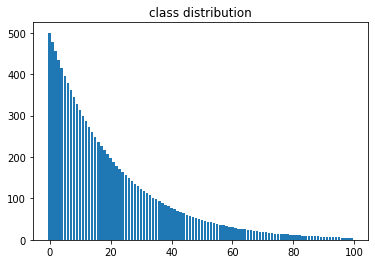

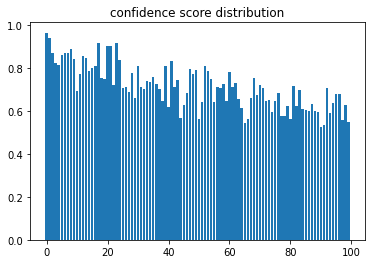

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
train_dataset = IMBALANCECIFAR100(root='./data', imb_type='exp', imb_factor=0.01, rand_number=0, train=True, download=True, transform=transform_train)
cls_freq = train_dataset.get_cls_num_list()
cls_freq = np.array(cls_freq)

model = ResNet18().to(device)
ckpt_dir = os.path.join('CIFAR_LT0.01_LS0.1/best_model_lt0.01_LS_0.0.pth.tar')
model.load_state_dict(torch.load(ckpt_dir))
model.eval()
conf_list = np.zeros(100)
total, correct = 0, 0
with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(testloader):
        inputs, targets = inputs.to(device), targets.to(device)
        logits = model(inputs)
        softmaxes = F.softmax(logits, dim=1)
        confidences, predictions = torch.max(softmaxes, 1)
        accuracies = predictions.eq(targets)
        total += targets.size(0)
        correct += predictions.eq(targets).sum().item()
        #print(confidences.max(),accuracies)
        for i in range(len(targets)):
            conf_list[targets[i]] += confidences[i]
print('Acc:',correct*100/total)

plt.figure(1)
plt.title('class distribution')
plt.bar(np.arange(len(cls_freq)),cls_freq)
plt.figure(2)
plt.title('confidence score distribution')
plt.bar(np.arange(len(cls_freq)),conf_list/100)

plt.savefig('cifar_lt0.01.pdf', dpi=300)

## Evaluation: CDA-TS (ratio: 10)

In [ ]:
args.imb_factor = 0.1
seed_everything()
train_dataset = IMBALANCECIFAR100(root='./data', imb_type='exp', imb_factor=args.imb_factor, rand_number=0, train=True, download=True, transform=transform_train)

model = ResNet18().to(device)
model_dir = 'CIFAR_LT0.1_LS0.1/best_model_lt0.1_LS_0.0.pth.tar'
model.load_state_dict(torch.load(model_dir))
model.eval()
ece_criterion = _ECELoss().to(device)

loss, acc, logits_all, labels_all = evaluation(model, testloader, temp=1)
temperature_ece = ece_criterion(logits_all, labels_all).item()
print('Before TS- loss:%.3f, acc:%.3f, bef ece:%.5f'%(loss, acc,temperature_ece))

model_ts = ModelWithTemperature(model)
model_ts.set_temperature(testloader)
loss, acc, logits_all_ts, labels_all_ts = evaluation(model_ts, testloader)
temperature_ece = ece_criterion(logits_all_ts, labels_all_ts).item()
print('After TS- loss:%.3f, acc:%.3f, aft ece:%.5f'%(loss, acc,temperature_ece))
print('Optimal Temperature:%.4f'%model_ts.temperature.item())

#CDA-TS calculation
cls_freq = train_dataset.get_cls_num_list()
cls_freq_norm = cls_freq/np.max(cls_freq)
cls_freq_norm = torch.tensor(cls_freq_norm).float()
temp = model_ts.temperature.item() + cls_freq_norm*0.1
temp = temp.to(device)
loss, acc, logits_all_cts, labels_all_cts = evaluation(model, testloader, temp=temp)
temperature_ece = ece_criterion(logits_all_cts, labels_all_cts).item()
print('After Class-aware TS- loss:%.3f, acc:%.3f, aft ece:%.5f'%(loss, acc,temperature_ece))

Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified
Before TS- loss:1.925, acc:57.600, bef ece:0.18007
After TS- loss:1.698, acc:57.600, aft ece:0.04287
Optimal Temperature:1.5510
After Class-aware TS- loss:1.682, acc:57.930, aft ece:0.03480


Reliability Diagram

CDA-TS:, ece:0.0356, sce:0.0032, tace:0.0033, brier:0.5593, uce:0.0305
TS:, ece:0.0425, sce:0.0034, tace:0.0035, brier:0.5656, uce:0.0502
CE:, ece:0.1801, sce:0.0047, tace:0.0043, brier:0.6115, uce:0.2344


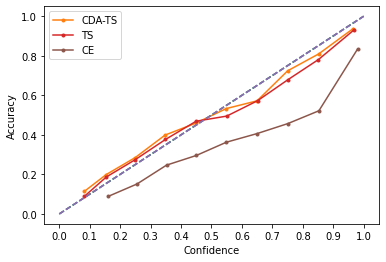

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def reliability_diagram_multi(conf_avg, acc_avg, legend=None, leg_idx=0, n_bins=10):
    plt.figure(2)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel('Confidence')
    plt.ylabel('Accuracy')
    plt.xticks(np.arange(0, 1.1, 1/n_bins))
    #plt.title(title)
    plt.plot(conf_avg[acc_avg>0],acc_avg[acc_avg>0], marker='.', label = legend)
    plt.legend()
    plt.savefig('ece_rel_CDA_TS_imb_{}.png'.format(args.imb_factor),dpi=300)

def calibration_metrics(logits_all, labels_all, model_name='Class-aware TS'):
    uce = uceloss( logits_all.cpu(), labels_all.cpu())
    logits = logits_all.detach().cpu().numpy()
    labels = labels_all.detach().cpu().numpy()
    ece, acc, conf, Bm = ece_eval(logits, labels, bg_cls=-1)
    sce = get_sce(logits, labels)
    tace = get_tace(logits, labels)
    brier = get_brier(logits, labels)
    print('%s:, ece:%0.4f, sce:%0.4f, tace:%0.4f, brier:%.4f, uce:%.4f' %(model_name, ece, sce, tace, brier, uce.item()) )
    reliability_diagram_multi(conf, acc, legend=model_name)

logits_all_sm = F.softmax(logits_all_cts, dim=1)
calibration_metrics(logits_all_sm, labels_all_cts, model_name='CDA-TS')

logits_all_sm = F.softmax(logits_all_ts, dim=1)
calibration_metrics(logits_all_sm, labels_all_ts, model_name='TS')

logits_all_sm = F.softmax(logits_all, dim=1)
calibration_metrics(logits_all_sm, labels_all, model_name='CE')

### Evaluation: CDA-TS (ratio: 100)

In [ ]:
args.imb_factor = 0.01
seed_everything()
train_dataset = IMBALANCECIFAR100(root='./data', imb_type='exp', imb_factor=args.imb_factor, rand_number=0, train=True, download=True, transform=transform_train)

model = ResNet18().to(device)
model_dir = 'CIFAR_LT0.01_LS0.1/best_model_lt0.01_LS_0.0.pth.tar'
model.load_state_dict(torch.load(model_dir))
model.eval()
ece_criterion = _ECELoss().to(device)

loss, acc, logits_all, labels_all = evaluation(model, testloader, temp=1)
temperature_ece = ece_criterion(logits_all, labels_all).item()
print('Before TS- loss:%.3f, acc:%.3f, bef ece:%.5f'%(loss, acc,temperature_ece))

model_ts = ModelWithTemperature(model)
model_ts.set_temperature(testloader)
loss, acc, logits_all_ts, labels_all_ts = evaluation(model_ts, testloader)
temperature_ece = ece_criterion(logits_all_ts, labels_all_ts).item()
print('After TS- loss:%.3f, acc:%.3f, aft ece:%.5f'%(loss, acc,temperature_ece))
print('Optimal Temperature:%.4f'%model_ts.temperature.item())

cls_freq = train_dataset.get_cls_num_list()
cls_freq_norm = cls_freq/np.max(cls_freq)
cls_freq_norm = torch.tensor(cls_freq_norm).float()
temp = model_ts.temperature.item() + cls_freq_norm*0.1
temp = temp.to(device)
loss, acc, logits_all_cts, labels_all_cts = evaluation(model, testloader, temp=temp)
temperature_ece = ece_criterion(logits_all_cts, labels_all_cts).item()
print('After Class-aware TS- loss:%.3f, acc:%.3f, aft ece:%.5f'%(loss, acc,temperature_ece))

Files already downloaded and verified
Before TS- loss:3.183, acc:38.570, bef ece:0.32799
After TS- loss:2.541, acc:38.570, aft ece:0.03658
Optimal Temperature:2.0147
After Class-aware TS- loss:2.527, acc:38.900, aft ece:0.03079


Reliability Diagram

CDA-TS:, ece:0.0280, sce:0.0046, tace:0.0055, brier:0.7526, uce:0.0099
TS:, ece:0.0372, sce:0.0047, tace:0.0056, brier:0.7580, uce:0.0194
CE:, ece:0.3280, sce:0.0082, tace:0.0071, brier:0.8976, uce:0.3892


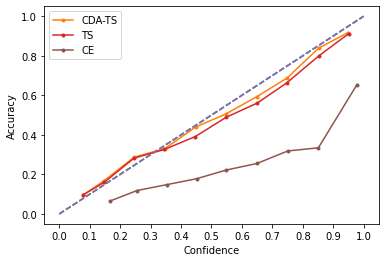

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def reliability_diagram_multi(conf_avg, acc_avg, legend=None, leg_idx=0, n_bins=10):
    plt.figure(2)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel('Confidence')
    plt.ylabel('Accuracy')
    plt.xticks(np.arange(0, 1.1, 1/n_bins))
    #plt.title(title)
    plt.plot(conf_avg[acc_avg>0],acc_avg[acc_avg>0], marker='.', label = legend)
    plt.legend()
    plt.savefig('ece_rel_CDA_TS_imb_{}.png'.format(args.imb_factor),dpi=300)

def calibration_metrics(logits_all, labels_all, model_name='Class-aware TS'):
    uce = uceloss( logits_all.cpu(), labels_all.cpu())
    logits = logits_all.detach().cpu().numpy()
    labels = labels_all.detach().cpu().numpy()
    ece, acc, conf, Bm = ece_eval(logits, labels, bg_cls=-1)
    sce = get_sce(logits, labels)
    tace = get_tace(logits, labels)
    brier = get_brier(logits, labels)
    print('%s:, ece:%0.4f, sce:%0.4f, tace:%0.4f, brier:%.4f, uce:%.4f' %(model_name, ece, sce, tace, brier, uce.item()) )
    reliability_diagram_multi(conf, acc, legend=model_name)

logits_all_sm = F.softmax(logits_all_cts, dim=1)
calibration_metrics(logits_all_sm, labels_all_cts, model_name='CDA-TS')

logits_all_sm = F.softmax(logits_all_ts, dim=1)
calibration_metrics(logits_all_sm, labels_all_ts, model_name='TS')

logits_all_sm = F.softmax(logits_all, dim=1)
calibration_metrics(logits_all_sm, labels_all, model_name='CE')

## Evaluation: CDA-LS (ratio: 10)

Results for CIFAR_LT:10
CDA-LS: accuracy:0.5835[top1:58.3630, top5:81.9594], ece:0.0782, sce:0.0040, tace:0.0053, brier:0.5679, uce:0.1375
LS: accuracy:0.5798[top1:58.0004, top5:81.6003], ece:0.0918, sce:0.0039, tace:0.0052, brier:0.5729, uce:0.1530
CE: accuracy:0.5760[top1:57.6513, top5:83.0928], ece:0.1801, sce:0.0047, tace:0.0043, brier:0.6115, uce:0.2344


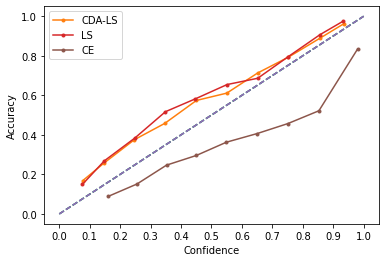

In [ ]:
seed_everything()
args.imb_factor = 0.1
print('Results for CIFAR_LT:10')
ckpt_list = ['best_model_lt0.1_CLS_0.1.pth.tar', 'best_model_lt0.1_LS_0.1.pth.tar', 'best_model_lt0.1_LS_0.0.pth.tar']
Legend = ['CDA-LS', 'LS', 'CE']
for idx in range(len(ckpt_list)):
    model = ResNet18().to(device)
    ckpt_dir = 'CIFAR_LT0.1_LS0.1/'+ckpt_list[idx]
    model.load_state_dict(torch.load(ckpt_dir))
    model.eval()
    model_name = Legend[idx]
    ece_avg, acc_bin, conf_bin, Bm = evaluation_all(model, testloader)
    reliability_diagram_multi(conf_bin, acc_bin, legend=Legend[idx])

## Evaluation: CDA-LS (ratio: 100)

Results for CIFAR_LT:100
CDA-LS: accuracy:0.3794[top1:37.9439, top5:60.7775], ece:0.0381, sce:0.0051, tace:0.0065, brier:0.7721, uce:0.0477
LS: accuracy:0.3790[top1:37.9191, top5:61.5528], ece:0.0449, sce:0.0050, tace:0.0064, brier:0.7784, uce:0.0400
CE: accuracy:0.3857[top1:38.5721, top5:67.2924], ece:0.3280, sce:0.0082, tace:0.0071, brier:0.8976, uce:0.3892


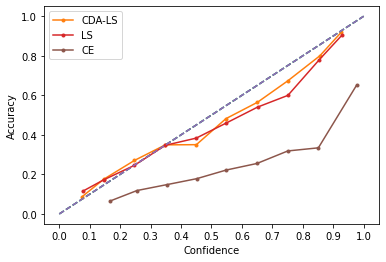

In [ ]:
seed_everything()
args.imb_factor = 0.01
print('Results for CIFAR_LT:100')
ckpt_list = ['best_model_lt0.01_CLS_0.1.pth.tar', 'best_model_lt0.01_LS_0.1.pth.tar', 'best_model_lt0.01_LS_0.0.pth.tar']
Legend = ['CDA-LS', 'LS', 'CE']
for idx in range(len(ckpt_list)):
    model = ResNet18().to(device)
    ckpt_dir = 'CIFAR_LT0.01_LS0.1/'+ckpt_list[idx]
    model.load_state_dict(torch.load(ckpt_dir))
    model.eval()
    model_name = Legend[idx]
    ece_avg, acc_bin, conf_bin, Bm = evaluation_all(model, testloader)
    reliability_diagram_multi(conf_bin, acc_bin, legend=Legend[idx])

## Self-Distillation (Retio: 10)

Teacher: loss:1.925, acc:57.600, bef ece:0.18007
Teacher:, ece:0.1801, sce:0.0047, tace:0.0043, brier:0.6115, uce:0.2344
SD Fixed T: loss:1.956, acc:57.640, bef ece:0.19739
SD Fixed T:, ece:0.1974, sce:0.0050, tace:0.0044, brier:0.6190, uce:0.2498
SD Opt. T: loss:1.868, acc:57.950, bef ece:0.17139
SD Opt. T:, ece:0.1714, sce:0.0046, tace:0.0042, brier:0.5992, uce:0.2264
SD CDA Opt. T: loss:1.843, acc:58.670, bef ece:0.16937
SD CDA Opt. T:, ece:0.1694, sce:0.0046, tace:0.0042, brier:0.5968, uce:0.2230


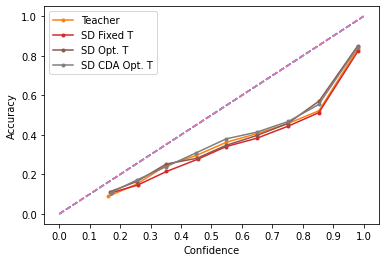

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def reliability_diagram_multi(conf_avg, acc_avg, legend=None, leg_idx=0, n_bins=10):
    plt.figure(2)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel('Confidence')
    plt.ylabel('Accuracy')
    plt.xticks(np.arange(0, 1.1, 1/n_bins))
    plt.plot(conf_avg[acc_avg>0],acc_avg[acc_avg>0], marker='.', label = legend)
    plt.legend()
    plt.savefig('ece_rel_CDA_TS_imb_{}.png'.format(args.imb_factor),dpi=300)

def calibration_metrics(logits_all, labels_all, model_name='Class-aware TS'):
    uce = uceloss( logits_all.cpu(), labels_all.cpu())
    logits = logits_all.detach().cpu().numpy()
    labels = labels_all.detach().cpu().numpy()
    ece, acc, conf, Bm = ece_eval(logits, labels, bg_cls=-1)
    sce = get_sce(logits, labels)
    tace = get_tace(logits, labels)
    brier = get_brier(logits, labels)
    print('%s:, ece:%0.4f, sce:%0.4f, tace:%0.4f, brier:%.4f, uce:%.4f' %(model_name, ece, sce, tace, brier, uce.item()) )
    reliability_diagram_multi(conf, acc, legend=model_name)
    
args.imb_factor = 0.1
seed_everything()
ckpt_dirs = ['best_model_lt0.1_LS_0.0.pth.tar','best_model_lt0.1_CTS_T_4.09_170.pth.tar', 'best_model_lt0.1_SD_T_1.551_188.pth.tar','best_model_lt0.1_CTS_T_1.651_189.pth.tar']
legend = ['Teacher', 'SD Fixed T', 'SD Opt. T','SD CDA Opt. T']
for idx in range(len(ckpt_dirs)):
    model = ResNet18().to(device)
    model_dir = 'ckpt_sd_final0.1/'+ckpt_dirs[idx]
    model.load_state_dict(torch.load(model_dir))
    model.eval()
    ece_criterion = _ECELoss().to(device)
    loss, acc, logits_all, labels_all = evaluation(model, testloader, temp=1)
    temperature_ece = ece_criterion(logits_all, labels_all).item()
    print('%s: loss:%.3f, acc:%.3f, bef ece:%.5f'%(legend[idx],loss, acc,temperature_ece))
    
    calibration_metrics(F.softmax(logits_all, dim=1), labels_all, model_name=legend[idx])

## Self-Distillation (Retio: 100)

Teacher: loss:3.183, acc:38.570, bef ece:0.32799
Teacher:, ece:0.3280, sce:0.0082, tace:0.0071, brier:0.8976, uce:0.3892
SD Fixed T: loss:3.280, acc:38.690, bef ece:0.34059
SD Fixed T:, ece:0.3406, sce:0.0085, tace:0.0072, brier:0.9131, uce:0.4012
SD Opt. T: loss:3.224, acc:38.610, bef ece:0.34077
SD Opt. T:, ece:0.3408, sce:0.0085, tace:0.0072, brier:0.9073, uce:0.3988
SD CDA Opt. T: loss:3.212, acc:38.870, bef ece:0.33717
SD CDA Opt. T:, ece:0.3372, sce:0.0084, tace:0.0071, brier:0.9033, uce:0.3971


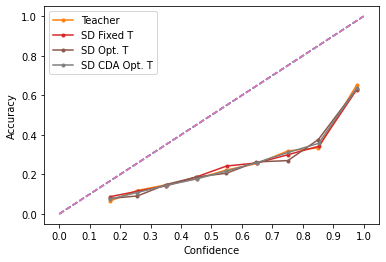

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def reliability_diagram_multi(conf_avg, acc_avg, legend=None, leg_idx=0, n_bins=10):
    plt.figure(2)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel('Confidence')
    plt.ylabel('Accuracy')
    plt.xticks(np.arange(0, 1.1, 1/n_bins))
    #plt.title(title)
    plt.plot(conf_avg[acc_avg>0],acc_avg[acc_avg>0], marker='.', label = legend)
    plt.legend()
    plt.savefig('ece_rel_CDA_TS_imb_{}.png'.format(args.imb_factor),dpi=300)

def calibration_metrics(logits_all, labels_all, model_name='Class-aware TS'):
    uce = uceloss( logits_all.cpu(), labels_all.cpu())
    logits = logits_all.detach().cpu().numpy()
    labels = labels_all.detach().cpu().numpy()
    ece, acc, conf, Bm = ece_eval(logits, labels, bg_cls=-1)
    sce = get_sce(logits, labels)
    tace = get_tace(logits, labels)
    brier = get_brier(logits, labels)
    print('%s:, ece:%0.4f, sce:%0.4f, tace:%0.4f, brier:%.4f, uce:%.4f' %(model_name, ece, sce, tace, brier, uce.item()) )
    reliability_diagram_multi(conf, acc, legend=model_name)
    
args.imb_factor = 0.01
seed_everything()
ckpt_dirs = ['best_model_lt0.01_LS_0.0.pth.tar','best_model_lt0.01_SD_T_4.0_168.pth.tar', 'best_model_lt0.01_SD_T_2.0147_263.pth.tar','best_model_lt0.01_CTS_T_4.09_299.pth.tar']
legend = ['Teacher', 'SD Fixed T', 'SD Opt. T','SD CDA Opt. T']
for idx in range(len(ckpt_dirs)):
    model = ResNet18().to(device)
    model_dir = 'ckpt_sd_final0.01/'+ckpt_dirs[idx]
    model.load_state_dict(torch.load(model_dir))
    model.eval()
    ece_criterion = _ECELoss().to(device)
    loss, acc, logits_all, labels_all = evaluation(model, testloader, temp=1)
    temperature_ece = ece_criterion(logits_all, labels_all).item()
    print('%s: loss:%.3f, acc:%.3f, bef ece:%.5f'%(legend[idx],loss, acc,temperature_ece))
    
    calibration_metrics(F.softmax(logits_all, dim=1), labels_all, model_name=legend[idx])